In [2]:
!pip install autogluon.timeseries

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 15.9 MB/s eta 0:00:00
  Using cached scikit_learn-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 7.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl (21.0 MB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl (849 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 142.5 MB/s eta 0:00:0000:0100:01
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl (557.1 MB)
  Using cached nvidia_cublas_cu11-11.10.3.66-

In [3]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
import os
import numpy as np
import matplotlib.pyplot as plt

# importo los .py
import sys
sys.path.append("auxiliares")

from warnings import simplefilter 
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)

Matplotlib is building the font cache; this may take a moment.


In [5]:
import numpy as np

def crear_target_prod_cust(df_param):
    df_param = df_param.sort_values(by=["prod_cust","periodo"],ascending=True)
    df_param["tn_mas_2"] = df_param.groupby("prod_cust")["tn"].shift(-2)
    return df_param

def crear_target_product(df_param):
    df_param = df_param.sort_values(by=["product_id","periodo"],ascending=True)
    df_param["tn_mas_2"] = df_param.groupby("product_id")["tn"].shift(-2)
    return df_param
    
def crear_nuevos_features(df_param):
    # Diferencia entre lo solicitado y lo entregado
    df_param["dif_cust_request_tn"]=df_param.cust_request_tn-df_param.tn
    df_param["dif_cust_request_tn_porc"]=np.where(df_param.cust_request_tn==0,0,100*df_param.dif_cust_request_tn/df_param.cust_request_tn)
   
    return df_param

def crear_features_temporales(campo,df_param,num_lag_params,familia_features_temporales):
    # Primero y FUNDAMENTAL, ordeno por el campo y periodo
    df_param = df_param.sort_values(by=[campo,"periodo"],ascending=True)

    if campo in ["prod_cust","product_id"]:
        prefijo_tn = ""
    else:
        prefijo_tn = campo + "_"
        
    for i in range(1, num_lag_params + 1):
        if "lags" in familia_features_temporales:
            df_param[campo + "_tn_lag_" + str(i)] = df_param.groupby(campo)[prefijo_tn + "tn"].shift(i)
        
        if "delta_lags" in familia_features_temporales:
            df_param[campo + "_tn_delta_lag_" + str(i)] = df_param.groupby(campo)[prefijo_tn + "tn"].diff(i)

        if "rolling_std" in familia_features_temporales:
            df_param[campo + "_tn_rolling_std_" + str(i)] = df_param.groupby(campo)[prefijo_tn+"tn"].rolling(window=i+1).std().reset_index(level=0, drop=True)
            
        if "rolling_mean" in familia_features_temporales:
            df_param[campo + "_tn_rolling_mean_" + str(i)] = df_param.groupby(campo)[prefijo_tn +"tn"].rolling(window=i+1).mean().reset_index(level=0, drop=True)
            
        if "rolling_sum" in familia_features_temporales:
            df_param[campo + "_tn_rolling_sum_" + str(i)] = df_param.groupby(campo)[prefijo_tn + "tn"].rolling(window=i+1).sum().reset_index(level=0, drop=True)

        if "bollinger_bands" in familia_features_temporales:
            df_param[campo + "_tn_bollinger_band_upper_" + str(i)] = df_param[campo + "_tn_rolling_mean_" + str(i)] + 2*df_param[campo + "_tn_rolling_std_" + str(i)]
            df_param[campo + "_tn_bollinger_band_lower_" + str(i)] = df_param[campo + "_tn_rolling_mean_" + str(i)] - 2*df_param[campo + "_tn_rolling_std_" + str(i)]

    return df_param


In [69]:
dataset = "datasets_emp3_sellout_producto_base.csv"

In [70]:
df_sellout = pd.read_csv(dataset)
df_sellout.head()

,product_id,periodo,product_id_tn,cero_ventas,cust_request_qty,cust_request_tn,mes,producto_estrella,plan_precios_cuidados,meses_historia_prod,cat1,cat2,cat3,sku_size,temp_media,temp_min_media,temp_max_media,IPC,promedio_mens_dolar_venta,catastrofe
0,20001,201701,934.77222,0,479.0,937.72717,1,1.0,0.0,0,HC,ROPA LAVADO,Liquido,3000.0,25.65,20.9,30.4,1.6,15.91,False
1,20001,201702,798.01620,0,432.0,833.72187,2,1.0,0.0,1,HC,ROPA LAVADO,Liquido,3000.0,25.35,20.6,30.1,2.1,15.59,False
2,20001,201703,1303.35771,0,509.0,1330.74697,3,1.0,0.0,2,HC,ROPA LAVADO,Liquido,3000.0,22.45,18.0,26.9,2.4,15.52,False
3,20001,201704,1069.96130,0,279.0,1132.94430,4,1.0,0.0,3,HC,ROPA LAVADO,Liquido,3000.0,18.90,14.3,23.5,2.7,15.36,False
4,20001,201705,1502.20132,0,701.0,1550.68936,5,1.0,0.0,4,HC,ROPA LAVADO,Liquido,3000.0,15.90,12.3,19.5,1.4,15.72,False


In [71]:
df_sellout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34707 entries, 0 to 34706
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   product_id                 34707 non-null  int64  
 1   periodo                    34707 non-null  int64  
 2   product_id_tn              34707 non-null  float64
 3   cero_ventas                34707 non-null  int64  
 4   cust_request_qty           34707 non-null  float64
 5   cust_request_tn            34707 non-null  float64
 6   mes                        34707 non-null  int64  
 7   producto_estrella          34707 non-null  float64
 8   plan_precios_cuidados      34707 non-null  float64
 9   meses_historia_prod        34707 non-null  int64  
 10  cat1                       34707 non-null  object 
 11  cat2                       34707 non-null  object 
 12  cat3                       34707 non-null  object 
 13  sku_size                   34707 non-null  flo

In [72]:
# Renombro tn
df_sellout = df_sellout.rename(columns={"product_id_tn":"tn"})

In [73]:
#variable target
df_sellout = crear_target_product(df_sellout)
df_sellout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34707 entries, 0 to 34706
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   product_id                 34707 non-null  int64  
 1   periodo                    34707 non-null  int64  
 2   tn                         34707 non-null  float64
 3   cero_ventas                34707 non-null  int64  
 4   cust_request_qty           34707 non-null  float64
 5   cust_request_tn            34707 non-null  float64
 6   mes                        34707 non-null  int64  
 7   producto_estrella          34707 non-null  float64
 8   plan_precios_cuidados      34707 non-null  float64
 9   meses_historia_prod        34707 non-null  int64  
 10  cat1                       34707 non-null  object 
 11  cat2                       34707 non-null  object 
 12  cat3                       34707 non-null  object 
 13  sku_size                   34707 non-null  flo

In [74]:
df_sellout.to_csv('datasets_emp3_sellout_producto_base_autogluon.csv', index=False)

In [75]:
df_sellout = pd.read_csv("datasets_emp3_sellout_producto_base_autogluon.csv")

In [76]:
# cambio el formato de periodo ya que autogluon no lo toma

df_sellout['periodo'] = df_sellout['periodo'].astype(str) 

# Extraigo año y mes
df_sellout['year'] = df_sellout['periodo'].str[:4]
df_sellout['month'] = df_sellout['periodo'].str[4:]

# Creo la variable periodo
df_sellout['periodo'] = pd.to_datetime(df_sellout['year'] + df_sellout['month'], format='%Y%m')
df_sellout['periodo2'] = pd.to_datetime(df_sellout['year'] + df_sellout['month'], format='%Y%m')
# Eliminar las columnas de más
df_sellout = df_sellout.drop(['year', 'month'], axis=1)



In [77]:
# Creo un diccionario de mapeo para cada columna de categoria ya que autogluon no toma object fields
cat1_mapping = {'HC': 1.0, 'FOODS': 2.0, 'PC': 3.0, 'desconocida': 4.0}  # Ajusta según tus categorías
cat2_mapping = {'ROPA LAVADO': 1.0,
    'ADEREZOS': 2.0,
    'VAJILLA': 3.0,
    'ROPA ACONDICIONADOR': 4.0,
    'HOGAR': 5.0,
    'SOPAS Y CALDOS': 6.0,
    'ROPA MANCHAS': 7.0,
    'CABELLO': 8.0,
    'PIEL2': 9.0,
    'OTROS': 10.0,
    'DEOS': 11.0,
    'PROFESIONAL': 12.0,
    'PIEL1': 13.0,
    'DENTAL': 14.0,
    'desconocida': 15.0,
    'TE': 16.0,
}
cat3_mapping = {'Liquido': 1.0,
    'Mayonesa': 2.0,
    'Cristalino': 3.0,
    'ACONDICIONADOR': 4.0,
    'Opaco': 5.0,
    'Polvo': 6.0,
    'Cremoso': 7.0,
    'Mostaza': 8.0,
    'Antigrasa': 9.0,
    'Ketchup': 10.0,
    'Caldo Cubo': 11.0,
    'Ladrillo': 12.0,
    'Gel': 13.0,
    'SHAMPOO': 14.0,
    'Salsas Wet': 15.0,
    'Pure de Tomate': 16.0,
    'Vidrios': 17.0,
    'Diluido': 18.0,
    'Barra': 19.0,
    'LAVANDINA EN GEL': 20.0,
    'Baño': 21.0,
    'Pure de Papas': 22.0,
    'Jabon Regular': 23.0,
    'Almidon': 24.0,
    'Talco': 25.0,
    'Pies Talco': 26.0,
    'Aero': 27.0,
    'Salsa Golf': 28.0,
    'Salsas': 29.0,
    'INDUSTRIAL': 30.0,
    'PISOS': 31.0,
    'Acond Mujer': 32.0,
    'Jabon Barra': 33.0,
    'SUAVIZANTE': 34.0,
    'Styling': 35.0,
    'Sopas': 36.0,
    'TOILETTE': 37.0,
    'BARRAS': 38.0,
    'Barbacoa': 39.0,
    'Concentrado': 40.0,
    'RollOn': 41.0,
    'NUTRICION': 42.0,
    'POST WASH': 43.0,
    'PurePapas': 44.0,
    'CREMA': 45.0,
    'Niños': 46.0,
    'DETOX': 47.0,
    'Jabon Antibacterial': 48.0,
    'Bizcochuelo': 49.0,
    'Jabon Glicerina': 50.0,
    'NoAero': 51.0,
    'Aji Picante': 52.0,
    'Baking Bags': 53.0,
    'Dishes': 54.0,
    'Shampoo Bebe': 55.0,
    'Stick': 56.0,
    'Sazonadores': 57.0,
    'Toallitas Bebe': 58.0,
    'Repelente': 59.0,
    'Cuerpo': 60.0,
    'LIQUIDOS': 61.0,
    'Pies NoAero': 62.0,
    'Tratamiento Fem': 63.0,
    'JABON LIQUIDO': 64.0,
    'LV ROPA POLVO': 65.0,
    'Jabon Barba': 66.0,
    'Caldos Granulados': 67.0,
    'Acond Bebe': 68.0,
    'LV ROPA LIQUIDO': 69.0,
    'Jabon Bebe': 70.0,
    'Chimichurri': 71.0,
    'Cara': 72.0,
    'Paño': 73.0,
    'desconocida': 74.0,
    'Tratamiento Masc': 75.0,
    'Pies Aero': 76.0,
    'Jabon Hotel': 77.0,
    'Pastas': 78.0,
    'Salsas Dry': 79.0,
    'Galletitas': 80.0,
    'Granolas': 81.0,
    'Azul': 82.0,
    'Gel Ducha': 83.0,
    'CUIDADO ESPECIAL': 84.0,
    'Cepilllo': 85.0,
    'Desmaquillante': 86.0,
    'PACKS': 87.0,
    'Limpieza Cara': 88.0,
    'Esponja': 89.0,
    'Especial': 90.0,
    'Limpieza': 91.0,
    'Verde': 92.0,
    'Hierbas': 93.0,
    'Frutas': 94.0,
}

# Aplicar el mapeo a cada columna
df_sellout['cat1'] = df_sellout['cat1'].map(cat1_mapping)
df_sellout['cat2'] = df_sellout['cat2'].map(cat2_mapping)
df_sellout['cat3'] = df_sellout['cat3'].map(cat3_mapping)

# Convertir las columnas a tipo float64
df_sellout['cat1'] = df_sellout['cat1'].astype('float64')
df_sellout['cat2'] = df_sellout['cat2'].astype('float64')
df_sellout['cat3'] = df_sellout['cat3'].astype('float64')

In [78]:
df_sellout.to_csv('datasets_emp3_sellout_producto_base_autogluon.csv', index=False)

In [79]:
# separato en train y test
mes_train_tope = "2019-02-01"
mes_holdout = "2019-04-01"
train_data = df_sellout[df_sellout.periodo <= mes_train_tope]
test_data = df_sellout[df_sellout.periodo == mes_holdout]

In [82]:
# como tengo productos que estan en 201904 pero no en el set de entramiento los quito
product_ids_entrenamiento = train_data['product_id'].unique()
test_data = test_data[test_data['product_id'].isin(product_ids_entrenamiento)]

In [83]:
test_data

,product_id,periodo,tn,cero_ventas,cust_request_qty,cust_request_tn,mes,producto_estrella,plan_precios_cuidados,meses_historia_prod,...,cat3,sku_size,temp_media,temp_min_media,temp_max_media,IPC,promedio_mens_dolar_venta,catastrofe,tn_mas_2,periodo2
27,20001,2019-04-01,1647.63848,0,478.0,1757.73271,4,1.0,0.0,27,...,1.0,3000.0,19.3,15.0,24.3,3.4,43.26,False,1109.93769,2019-04-01
62,20002,2019-04-01,1287.62346,0,454.0,1360.44402,4,1.0,0.0,27,...,1.0,3000.0,19.3,15.0,24.3,3.4,43.26,False,928.36431,2019-04-01
97,20003,2019-04-01,565.33774,0,282.0,569.69482,4,1.0,0.0,27,...,2.0,475.0,19.3,15.0,24.3,3.4,43.26,False,662.38654,2019-04-01
132,20004,2019-04-01,466.70901,0,346.0,468.21007,4,1.0,0.0,27,...,2.0,240.0,19.3,15.0,24.3,3.4,43.26,False,667.19411,2019-04-01
167,20005,2019-04-01,624.99880,0,327.0,629.64621,4,1.0,0.0,27,...,2.0,120.0,19.3,15.0,24.3,3.4,43.26,False,876.39696,2019-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34580,21295,2019-04-01,0.00000,1,0.0,0.00000,4,0.0,0.0,27,...,74.0,0.0,19.3,15.0,24.3,3.4,43.26,False,0.00000,2019-04-01
34608,21296,2019-04-01,0.00000,1,0.0,0.00000,4,0.0,0.0,20,...,74.0,0.0,19.3,15.0,24.3,3.4,43.26,False,0.00000,2019-04-01
34643,21297,2019-04-01,0.00000,1,0.0,0.00000,4,0.0,0.0,27,...,74.0,0.0,19.3,15.0,24.3,3.4,43.26,False,0.00000,2019-04-01
34671,21298,2019-04-01,0.00000,1,0.0,0.00000,4,0.0,0.0,20,...,74.0,0.0,19.3,15.0,24.3,3.4,43.26,False,0.00000,2019-04-01


In [87]:
train_data.to_csv('train_data_autogluon.csv', index=False)

In [88]:
test_data.to_csv('test_data_autogluon.csv', index=False)

In [135]:
#importo los dataset que le dan formato a autogluon
train_data = TimeSeriesDataFrame.from_path(path = "train_data_autogluon.csv", id_column = "product_id", timestamp_column = "periodo")
test_data = TimeSeriesDataFrame.from_path(path = "test_data_autogluon.csv", id_column = "product_id", timestamp_column = "periodo")

Loaded data from: train_data_autogluon.csv | Columns = 22 / 22 | Rows = 24224 -> 24224
Loaded data from: test_data_autogluon.csv | Columns = 22 / 22 | Rows = 1055 -> 1055


In [136]:
train_data

tn  cero_ventas  cust_request_qty  \
item_id timestamp                                               
20001   2017-01-01   934.77222            0             479.0   
        2017-02-01   798.01620            0             432.0   
        2017-03-01  1303.35771            0             509.0   
        2017-04-01  1069.96130            0             279.0   
        2017-05-01  1502.20132            0             701.0   
...                        ...          ...               ...   
21299   2018-10-01     0.00000            1               0.0   
        2018-11-01     0.00000            1               0.0   
        2018-12-01     0.00000            1               0.0   
        2019-01-01     0.00000            1               0.0   
        2019-02-01     0.00000            1               0.0   

                    cust_request_tn  mes  producto_estrella  \
item_id timestamp                                             
20001   2017-01-01        937.72717    1                1.0   
        2017-02-01        833.72187    2                1.0   
        2017-03-01       1330.74697    3                1.0   
        2017-04-01       1132.94430    4                1.0   
        2017-05-01       1550.68936    5                1.0   
...                             ...  ...                ...   
21299   2018-10-01          0.00000   10                0.0   
        2018-11-01          0.00000   11                0.0   
        2018-12-01          0.00000   12                0.0   
        2019-01-01          0.00000    1                0.0   
        2019-02-01          0.00000    2                0.0   

                    plan_precios_cuidados  meses_historia_prod  cat1  cat2  \
item_id timestamp                                                            
20001   2017-01-01                    0.0                    0   1.0   1.0   
        2017-02-01                    0.0                    1   1.0   1.0   
        2017-03-01                    0.0                    2   1.0   1.0   
        2017-04-01                    0.0                    3   1.0   1.0   
        2017-05-01                    0.0                    4   1.0   1.0   
...                                   ...                  ...   ...   ...   
21299   2018-10-01                    0.0                   14   4.0  15.0   
        2018-11-01                    0.0                   15   4.0  15.0   
        2018-12-01                    0.0                   16   4.0  15.0   
        2019-01-01                    0.0                   17   4.0  15.0   
        2019-02-01                    0.0                   18   4.0  15.0   

                    cat3  sku_size  temp_media  temp_min_media  \
item_id timestamp                                                
20001   2017-01-01   1.0    3000.0       25.65            20.9   
        2017-02-01   1.0    3000.0       25.35            20.6   
        2017-03-01   1.0    3000.0       22.45            18.0   
        2017-04-01   1.0    3000.0       18.90            14.3   
        2017-05-01   1.0    3000.0       15.90            12.3   
...                  ...       ...         ...             ...   
21299   2018-10-01  74.0       0.0       18.00            13.2   
        2018-11-01  74.0       0.0       21.60            16.7   
        2018-12-01  74.0       0.0       22.60            17.6   
        2019-01-01  74.0       0.0       24.90            20.7   
        2019-02-01  74.0       0.0       24.20            19.2   

                    temp_max_media  IPC  promedio_mens_dolar_venta  \
item_id timestamp                                                    
20001   2017-01-01            30.4  1.6                      15.91   
        2017-02-01            30.1  2.1                      15.59   
        2017-03-01            26.9  2.4                      15.52   
        2017-04-01            23.5  2.7                      15.36   
        2017-05-01            19.5  1.4                      15.72  

In [137]:
test_data

,,tn,cero_ventas,cust_request_qty,cust_request_tn,mes,producto_estrella,plan_precios_cuidados,meses_historia_prod,cat1,cat2,cat3,sku_size,temp_media,temp_min_media,temp_max_media,IPC,promedio_mens_dolar_venta,catastrofe,tn_mas_2,periodo2
item_id,timestamp,,,,,,,,,,,,,,,,,,,,
20001,2019-04-01,1647.63848,0,478.0,1757.73271,4,1.0,0.0,27,1.0,1.0,1.0,3000.0,19.3,15.0,24.3,3.4,43.26,False,1109.93769,2019-04-01
20002,2019-04-01,1287.62346,0,454.0,1360.44402,4,1.0,0.0,27,1.0,1.0,1.0,3000.0,19.3,15.0,24.3,3.4,43.26,False,928.36431,2019-04-01
20003,2019-04-01,565.33774,0,282.0,569.69482,4,1.0,0.0,27,2.0,2.0,2.0,475.0,19.3,15.0,24.3,3.4,43.26,False,662.38654,2019-04-01
20004,2019-04-01,466.70901,0,346.0,468.21007,4,1.0,0.0,27,2.0,2.0,2.0,240.0,19.3,15.0,24.3,3.4,43.26,False,667.19411,2019-04-01
20005,2019-04-01,624.99880,0,327.0,629.64621,4,1.0,0.0,27,2.0,2.0,2.0,120.0,19.3,15.0,24.3,3.4,43.26,False,876.39696,2019-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21295,2019-04-01,0.00000,1,0.0,0.00000,4,0.0,0.0,27,4.0,15.0,74.0,0.0,19.3,15.0,24.3,3.4,43.26,False,0.00000,2019-04-01
21296,2019-04-01,0.00000,1,0.0,0.00000,4,0.0,0.0,20,4.0,15.0,74.0,0.0,19.3,15.0,24.3,3.4,43.26,False,0.00000,2019-04-01
21297,2019-04-01,0.00000,1,0.0,0.00000,4,0.0,0.0,27,4.0,15.0,74.0,0.0,19.3,15.0,24.3,3.4,43.26,False,0.00000,2019-04-01


In [138]:
# elimino nulos ya que no corre con valores nulos

train_data = TimeSeriesDataFrame.dropna(train_data,how = "any" )
test_data = TimeSeriesDataFrame.dropna(test_data,how = "any" )

In [139]:
#train_data = TimeSeriesDataFrame.convert_frequency(df_sellout, freq = "M")
#test_data = TimeSeriesDataFrame.convert_frequency(df_sellout, freq = "M")

In [140]:
cols_remover_entren = ["periodo2"]
train_data = train_data.drop(columns=cols_remover_entren, axis=1)
test_data = test_data.drop(columns=cols_remover_entren, axis=1)

In [141]:
predictor = TimeSeriesPredictor(
    prediction_length=2,
    path="buckets/b1/datasets/models",
    target="tn_mas_2",
    eval_metric="MASE",
    #known_covariates_names=["cero_ventas","sku_size","cat1","cat2","cat3", "promedio_mens_dolar_venta", "IPC" ],
    freq= "M",
)

predictor.fit(
    train_data,
    presets="best_quality",
    time_limit=3600,
    hyperparameters={
        "DeepAR": {},
        "Theta": [
            {"decomposition_type": "additive"},
            {"seasonal_period": 1},
        ],
    }
)


Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'buckets/b1/datasets/models'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #20~22.04.1-Ubuntu SMP Mon Oct 23 12:29:43 UTC 2023
CPU Count:          8
GPU Count:          0
Memory Avail:       248.49 GB / 251.69 GB (98.7%)
Disk Space Avail:   1048576.00 GB / 1048576.00 GB (100.0%)
Setting presets to: best_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'M',
 'hyperparameters': {'DeepAR': {},
                     'Theta': [{'decomposition_type': 'additive'},
                               {'seasonal_period': 1}]},
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 2,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'target'

In [142]:
predictions = predictor.predict(train_data)
predictions

data with frequency 'None' has been resampled to frequency 'M'.
Model not specified in predict, will default to the model with the best validation score: Theta


mean          0.1          0.2          0.3  \
item_id timestamp                                                        
20001   2019-03-31  1556.277222  1172.173779  1281.127588  1361.409949   
        2019-04-30  1498.024658  1140.408850  1279.032153  1363.252429   
20002   2019-03-31  1211.239990   954.902295  1027.614355  1081.192090   
        2019-04-30  1177.148621   938.774469  1032.258765  1085.900232   
20003   2019-03-31   578.571960   220.443176   322.029053   396.882388   
...                         ...          ...          ...          ...   
21297   2019-04-30     0.000000     0.000000     0.000000     0.000000   
21298   2019-03-31     0.000000     0.000000     0.000000     0.000000   
        2019-04-30     0.000000     0.000000     0.000000     0.000000   
21299   2019-03-31     0.000000     0.000000     0.000000     0.000000   
        2019-04-30     0.000000     0.000000     0.000000     0.000000   

                            0.4          0.5          0.6          0.7  \
item_id timestamp                                                        
20001   2019-03-31  1469.587207  1556.277222  1649.330566  1732.183179   
        2019-04-30  1436.621143  1498.024658  1582.822876  1657.094495   
20002   2019-03-31  1153.385986  1211.239990  1273.340576  1328.633667   
        2019-04-30  1135.993433  1177.148621  1234.474121  1282.775244   
20003   2019-03-31   497.744287   578.571960   665.332617   742.582440   
...                         ...          ...          ...          ...   
21297   2019-04-30     0.000000     0.000000     0.000000     0.000000   
21298   2019-03-31     0.000000     0.000000     0.000000     0.000000   
        2019-04-30     0.000000     0.000000     0.000000     0.000000   
21299   2019-03-31     0.000000     0.000000     0.000000     0.000000   
        2019-04-30     0.000000     0.000000     0.000000     0.000000   

                            0.8          0.9  
item_id timestamp                             
20001   2019-03-31  1824.292578  1986.612646  
        2019-04-30  1740.058398  1864.767944  
20002   2019-03-31  1390.104395  1498.431335  
        2019-04-30  1337.445630  1423.288257  
20003   2019-03-31   828.463049   979.806329  
...                         ...          ...  
21297   2019-04-30     0.000000     0.000000  
21298   2019-03-31     0.000000     0.000000  
        2019-04-30     0.000000     0.000000  
21299   2019-03-31     0.000000     0.000000  
        2019-04-30     0.000000     0.000000  

[2110 rows x 10 columns]

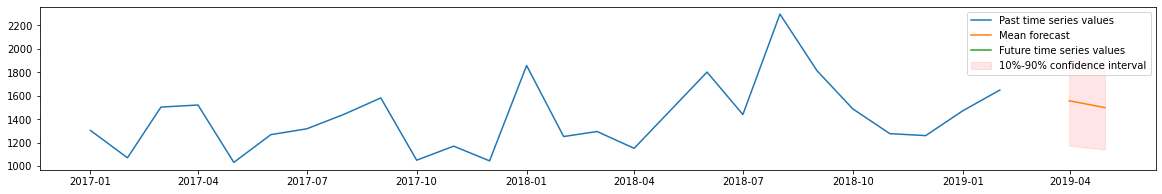

In [143]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 3))

item_id = 20001
y_past = train_data.loc[item_id]["tn_mas_2"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["tn_mas_2"][-1:]

plt.plot(y_past[-200:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend();

In [144]:
def error_rate(y, y_pred):
    y = np.array(y)
    y_pred = np.array(y_pred)
    
    #Las predicciones negativas se convierten a 0
    y_pred = np.maximum(y_pred, 0)
    
    dif_abs = sum(abs(y - y_pred))
    suma_real = sum(y)

    if suma_real > 0:
        er = round(100*dif_abs/suma_real,2)
    else:
        er = 0
        
    return er

In [145]:
from datetime import datetime
import pandas as pd

# Convierte la cadena '2019-04-30' a un objeto pd.Timestamp
cutoff_time = pd.Timestamp(datetime.strptime('2019-04-30', '%Y-%m-%d'))

# Luego, utiliza la función split_by_time para quedarme solo con las predicciones de abril
predictions_april = predictions.split_by_time(cutoff_time=cutoff_time)

# El codigo anterior me separa el dataframe dentro de una tupla y ahora solo necesito filtrar los valores que me interesan
predictions_april = predictions_april[1].loc[(slice(None), '2019-04-30'), :]

# Visualiza los valores obtenidos
print(predictions_april)


                           mean          0.1          0.2          0.3  \
item_id timestamp                                                        
20001   2019-04-30  1498.024658  1140.408850  1279.032153  1363.252429   
20002   2019-04-30  1177.148621   938.774469  1032.258765  1085.900232   
20003   2019-04-30   534.267761    42.736390   204.435440   323.345670   
20004   2019-04-30   445.206635    97.146504   211.647855   295.849808   
20005   2019-04-30   596.178619   214.219853   339.872772   432.275500   
...                         ...          ...          ...          ...   
21295   2019-04-30     0.000000     0.000000     0.000000     0.000000   
21296   2019-04-30     0.000000     0.000000     0.000000     0.000000   
21297   2019-04-30     0.000000     0.000000     0.000000     0.000000   
21298   2019-04-30     0.000000     0.000000     0.000000     0.000000   
21299   2019-04-30     0.000000     0.000000     0.000000     0.000000   

                            0.4      

In [146]:
# Filtrar los datos reales para la fecha deseada (2019-04-30)
test_data = test_data['tn_mas_2']

# me quedo solo con el promedio de la prediccion
prediction_values = predictions_april['mean']

# Tengo 4 predicionesn NaN por lo que las reemplazo con 0 para calcular la metrica
nan_indices = np.isnan(prediction_values)
prediction_values[nan_indices] = 0



In [147]:
# Calcular el error utilizando la función error_rate
error = error_rate(test_data, prediction_values)

# Visualizar el error
print(f'Error para abril de 2019: {error}%')

Error para abril de 2019: 31.13%
